Ce notebook est dédié au classifier (Lyrics to genre) du projet NLP.
Commençons par importer les différents packages

In [1]:
!pip install tiktoken
import nltk

nltk.download('punkt')
nltk.download('wordnet')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.2 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [1]:
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import tiktoken
import os

from google.colab import userdata
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
from sklearn.naive_bayes import MultinomialNB


KeyboardInterrupt: 

Ensuite vous aurez besoin de récupérer le dataset en provenance de kaggle.
Pour se faire, je vous prie de suivre ce tuto
https://www.kaggle.com/discussions/general/74235#2580958


In [5]:

!pip install kaggle

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
!kaggle datasets download -d carlosgdcj/genius-song-lyrics-with-language-information
!unzip genius-song-lyrics-with-language-information.zip

100% 3.04G/3.04G [01:35<00:00, 40.8MB/s]
100% 3.04G/3.04G [01:35<00:00, 34.0MB/s]
Archive:  genius-song-lyrics-with-language-information.zip
  inflating: song_lyrics.csv         


Etape de préprocessing 'rapide'.

In [6]:
# n = 100 every 100th line = 1% of the lines 50 000 lines taken
df = pd.read_csv("song_lyrics.csv", skiprows=lambda i: i % 100 != 0)
print(df.index)
df = df[df['tag'] != 'misc']
if 'language' in df.columns:
    df = df[df['language'] == 'en']
df = df[['title', 'lyrics', 'tag']]
df.reset_index(drop=True, inplace=True)
# To shuffle randomnly datas
df = df.sample(frac = 1)
# Split the data into features (X) and labels (Y)
X = df['lyrics']
Y = df['tag']

# Split the data into training and test sets (80% training, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

RangeIndex(start=0, stop=51348, step=1)


Utilisons les tokenizers vu en cours encore une fois dans un soucis de rapidité

In [4]:
#Define tokenizers from course
def lemma_tokenize(doc):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(t) for t in word_tokenize(doc)]

def char_tokenize(doc):
    return [char for char in doc]

def byte_tokenize(doc):
    tokens = doc.encode("utf-8")
    tokens = list(map(int, tokens))
    return [str(token) for token in tokens]

def gpt_tokenize(doc):
    enc = tiktoken.encoding_for_model("gpt-4")
    tokens = enc.encode(doc)
    return [str(token) for token in tokens]

Création du classifier en utilisant scikit-learn
On peut s'amuser à jouer sur les différents paramètres et hyperparamètres pour voir si on obtient de meilleur résultats

In [9]:
# Create model, we can test them one by one or even customize them using hyperparameters tunning
model = make_pipeline(CountVectorizer(ngram_range = (1,1), stop_words = list(en_stop)), MultinomialNB()) #Naive Bayes
#model = make_pipeline(CountVectorizer(ngram_range = (1,1), stop_words = en_stop), LogisticRegression()) #Logistic Regression
model.fit(X_train, Y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words=['under', 'who', 'bottom',
                                             'hereupon', 'me', 'everyone',
                                             'while', 'hereby', 'however',
                                             'those', 'within', 'wherever',
                                             're', '‘re', 'always', 'together',
                                             'six', 'mostly', 'seemed', 'forty',
                                             'there', 'beyond', 'none', 'also',
                                             'beside', 'noone', 'cannot',
                                             'seem', 'beforehand', 'already', ...])),
                ('multinomialnb', MultinomialNB())])

On évalue dans un premier temps le modèle simplement en regardant sa précision.

In [10]:
accuracy = model.score(X_test, Y_test)
print("Accuracy:", accuracy)

Accuracy: 0.6297507788161993


Ce-dessous une liste de toutes les combinaisons qui ont été testées une par une. Pour obtenir une vue des résultats : voir l'annexe dans le repo github.

In [12]:
model = make_pipeline(CountVectorizer(tokenizer=gpt_tokenize, ngram_range=(1, 1)), StandardScaler(with_mean=False), LogisticRegression( max_iter = 1000, solver='saga',penalty='l2'))
#model = make_pipeline(CountVectorizer(tokenizer=byte_tokenize, ngram_range=(1, 1)), scaler, LogisticRegression( max_iter = 1000, solver='saga',penalty='l2'))
#model = make_pipeline(CountVectorizer(tokenizer=word_tokenize, ngram_range=(1, 1)), scaler, LogisticRegression( max_iter = 1000, solver='saga',penalty='l2'))
#model = make_pipeline(CountVectorizer(ngram_range=(1, 1), scaler, LogisticRegression( max_iter = 3000, solver='lbfgs'))
#model = make_pipeline(CountVectorizer(ngram_range=(1, 2), scaler, LogisticRegression( max_iter = 3000, solver='lbfgs'))


#model = make_pipeline(CountVectorizer(tokenizer=word_tokenize, ngram_range=(1, 1)), scaler, LogisticRegression( max_iter = 1000, solver='saga',penalty='elasticnet', l1-ratio=0.5))


Voici comment évaluer le modèle de manière plus pertinente.
On se permet d'utiliser

*   La matrice de confusion
*   Le classification report fourni par sk-learn
*   L'évaluation empirique

Matrice de confusion : on voit précisément où le modèle s'est trompé / où il a bien prédit



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification Report:
               precision    recall  f1-score   support

     country       0.20      0.06      0.09       168
         pop       0.60      0.71      0.65      2736
         rap       0.81      0.80      0.80      1980
          rb       0.19      0.07      0.11       308
        rock       0.40      0.34      0.36      1228

    accuracy                           0.62      6420
   macro avg       0.44      0.40      0.40      6420
weighted avg       0.59      0.62      0.60      6420



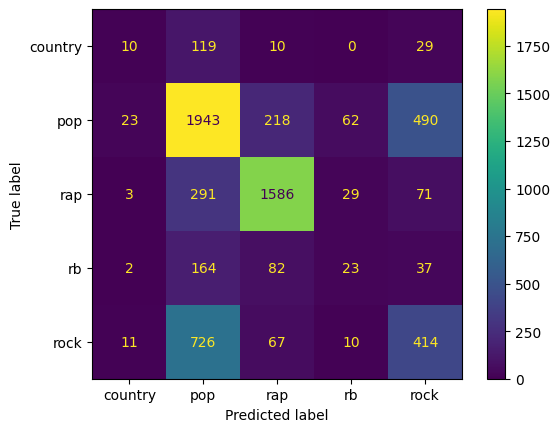

In [17]:
# Print classification report and confusion matrix
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(Y_test, Y_pred))
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

Classification report : qu'on envoit vers un fichier excel pour ensuite le comparer avec d'autres itérations

In [ ]:
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(Y_test, y_pred))
# Convert classification report to dictionary
report_dict = classification_report(Y_test, y_pred, output_dict=True)

# Convert the dictionary to a DataFrame
df_excel = pd.DataFrame(report_dict).transpose()

# Convert the DataFrame to Excel format
df_excel.to_excel("classification_report.xlsx")

Tests empirique 'visuels' : on prend au hasard certaines musiques.
Et on regarde si notre modèle performe bien dessus ou pas.
Enfin on affiche les erreurs/réussites

In [18]:
df_test = pd.read_csv("song_lyrics.csv", skiprows=lambda i: i % 977 != 0 , nrows=10) # Change here to test different values

df_test = df_test[df_test['tag'] != 'misc']
if 'language' in df_test.columns:
    df_test = df_test[df_test['language'] == 'en']
df_test = df_test[['title', 'lyrics', 'tag']]
df_test.reset_index(drop=True, inplace=True)

for song_name, song_lyrics, song_tag in zip(df_test['title'], df_test['lyrics'], df_test['tag']):
    print("Song:", song_name)
    print("Tag:", song_tag)
    # Convert the lyrics to a list and predict probabilities
    probabilities = model.predict_proba([song_lyrics])

    # Print the distribution of probabilities
    print("Distribution of Probabilities:")
    for class_label, probability in zip(model.classes_, probabilities[0]):
        if(probability > 0.0001):
          print(f"{class_label}: {probability:.4f}")
    max_prob_index = probabilities.argmax()
    predicted_class = model.classes_[max_prob_index]
    if predicted_class != song_tag:
        print(f'Model failed to predict. Actual tag is {song_tag}, predicted tag is {predicted_class}')
    print()

Song: Verbal Intercourse
Tag: rap
Distribution of Probabilities:
pop: 0.0011
rap: 0.9989

Song: Friends and Neighbors
Tag: rap
Distribution of Probabilities:
pop: 0.0005
rap: 0.9954
rock: 0.0040

Song: The Rabbit Hole
Tag: rap
Distribution of Probabilities:
pop: 0.1847
rap: 0.7748
rb: 0.0007
rock: 0.0396

Song: Ok Youre Right
Tag: rap
Distribution of Probabilities:
pop: 0.0004
rap: 0.9939
rb: 0.0056

Song: Move Back
Tag: rap
Distribution of Probabilities:
pop: 0.0002
rap: 0.9988
rock: 0.0010

Song: Beneath the Surface
Tag: rap
Distribution of Probabilities:
rap: 0.9005
rock: 0.0995

Song: 7A3 Will Rock You
Tag: rap
Distribution of Probabilities:
country: 0.0005
pop: 0.3607
rap: 0.5417
rb: 0.0013
rock: 0.0957

Song: Lights Out Partys Over
Tag: rap
Distribution of Probabilities:
rap: 1.0000

Song: Its On All Day
Tag: rap
Distribution of Probabilities:
country: 0.0007
pop: 0.6253
rap: 0.3503
rb: 0.0024
rock: 0.0212
Model failed to predict. Actual tag is rap, predicted tag is pop

Song: Ca

Dans une optique de performance nous avons décidé de voir ce si les perfomances étaient meilleures sans utiliser scikit-learn

Passons donc maintenant à l'implementation du classifer à l'aide de PyTorch.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import LabelEncoder

In [ ]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


Y_train_vec = vectorizer.fit_transform(Y_train)
Y_test_vec = vectorizer.transform(Y_test)

In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_vec.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_vec.toarray(), dtype=torch.float32)

label_encoder = LabelEncoder()
Y_train_indices = label_encoder.fit_transform(Y_train)
Y_test_indices = label_encoder.transform(Y_test)

Y_train_tensor = torch.tensor(Y_train_indices, dtype=torch.long)
Y_test_tensor = torch.tensor(Y_test_indices, dtype=torch.long)

In [ ]:
# Define logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.linear(x)
        return out

input_size = X_train_tensor.shape[1]
num_classes = len(Y_train.unique())


On utilise la CrossEntropy Loss et l'optimizer Adam

In [ ]:
# Initialize the model
model = LogisticRegression(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
print(X_train_tensor.shape)
print(X_test_tensor.shape)
print(Y_train_tensor.shape)

torch.Size([25680, 79784])
torch.Size([6420, 79784])
torch.Size([25680])


In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    # Training phase
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, Y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        _, predicted_val = torch.max(val_outputs, dim=1)
        num_correct = (predicted_val == Y_test_tensor).sum().item()
        accuracy = num_correct / Y_test_tensor.size(0) * 100

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')

Epoch [1/100], Loss: 1.5848, Accuracy: 56.04%
Epoch [2/100], Loss: 1.5431, Accuracy: 61.50%
Epoch [3/100], Loss: 1.4722, Accuracy: 66.09%
Epoch [4/100], Loss: 1.1467, Accuracy: 48.68%
Epoch [5/100], Loss: 1.1932, Accuracy: 47.96%
Epoch [6/100], Loss: 1.1179, Accuracy: 63.52%
Epoch [7/100], Loss: 0.8890, Accuracy: 65.69%
Epoch [8/100], Loss: 0.8240, Accuracy: 65.59%
Epoch [9/100], Loss: 0.7766, Accuracy: 65.87%
Epoch [10/100], Loss: 0.7327, Accuracy: 61.88%
Epoch [11/100], Loss: 0.7472, Accuracy: 61.03%
Epoch [12/100], Loss: 0.7038, Accuracy: 63.15%
Epoch [13/100], Loss: 0.6065, Accuracy: 64.58%
Epoch [14/100], Loss: 0.5279, Accuracy: 64.97%
Epoch [15/100], Loss: 0.4877, Accuracy: 65.12%
Epoch [16/100], Loss: 0.4731, Accuracy: 65.09%
Epoch [17/100], Loss: 0.4710, Accuracy: 64.95%
Epoch [18/100], Loss: 0.4712, Accuracy: 64.74%
Epoch [19/100], Loss: 0.4654, Accuracy: 64.44%
Epoch [20/100], Loss: 0.4510, Accuracy: 64.13%
Epoch [21/100], Loss: 0.4298, Accuracy: 64.14%
Epoch [22/100], Loss: 

KeyboardInterrupt: 

Evaluation du modèle

In [ ]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)

cm = confusion_matrix(Y_test_tensor.numpy(), predicted.numpy())
print(cm)
report = classification_report(Y_test_tensor.numpy(), predicted.numpy())
print(report)